## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

2024-04-22 17:36:27.995835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 17:36:27.995935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 17:36:28.115271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exploring Dataset

In [4]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


<Axes: >

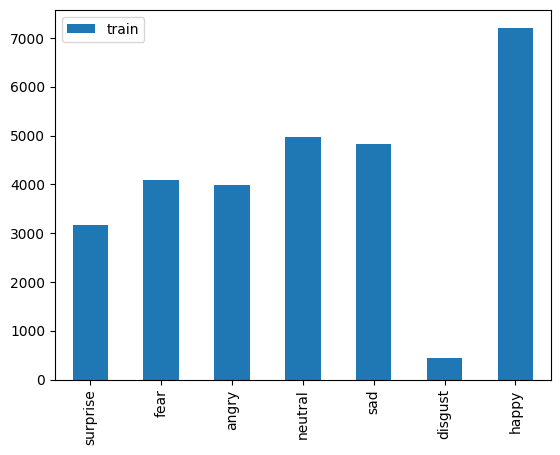

In [5]:
train_count.transpose().plot(kind='bar')

<Axes: >

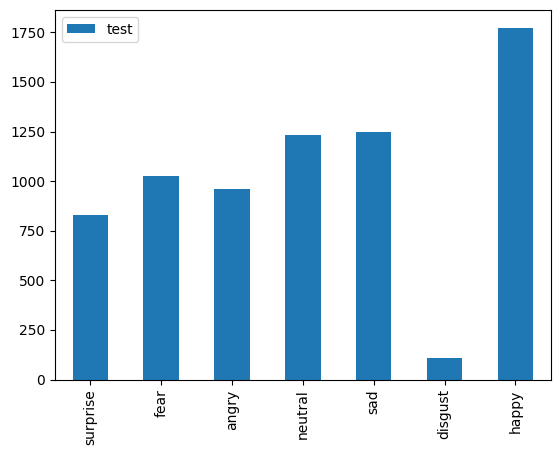

In [6]:
test_count.transpose().plot(kind='bar')

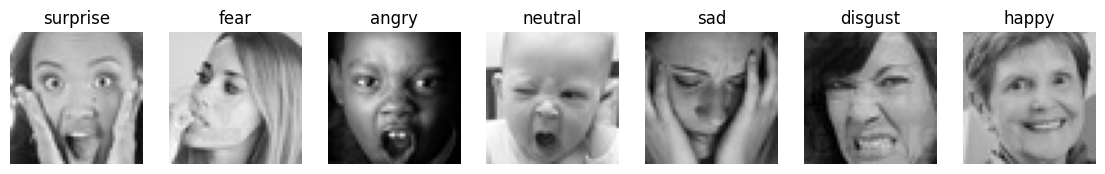

In [7]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating train test and validation datasets

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='training')
validation_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
# labels 
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Model Architecture

In [10]:
weight_decay = 1e-4

num_classes = 7

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])
 
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,315,335 (5.02 MB)

 Trainable params: 1,314,311 (5.01 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [12]:

checkpointer = [
    EarlyStopping(
        monitor='val_accuracy',
        verbose=1,
        restore_best_weights=True,
        mode="max",
        patience=10
    ),
    ModelCheckpoint(
        filepath='model.weights.best.keras',  # Adjusted filepath
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="max"
    )
]


## Model Training

In [13]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=200,
                 #callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/358 ━━━━━━━━━━━━━━━━━━━━ 1:33:03 16s/step - accuracy: 0.1875 - loss: 3.7588

I0000 00:00:1713807498.702130     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


358/358 ━━━━━━━━━━━━━━━━━━━━ 118s 287ms/step - accuracy: 0.2816 - loss: 2.1240 - val_accuracy: 0.2900 - val_loss: 2.1912
Epoch 2/200
  1/358 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3594 - loss: 1.6986

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3594 - loss: 1.6986 - val_accuracy: 0.2000 - val_loss: 2.7024
Epoch 3/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.3941 - loss: 1.5966 - val_accuracy: 0.4331 - val_loss: 1.5217
Epoch 4/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.4375 - loss: 1.4741 - val_accuracy: 0.5333 - val_loss: 1.3409
Epoch 5/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.4409 - loss: 1.4827 - val_accuracy: 0.4528 - val_loss: 1.4770
Epoch 6/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.3438 - loss: 1.7068 - val_accuracy: 0.5556 - val_loss: 1.4872
Epoch 7/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.4848 - loss: 1.3817 - val_accuracy: 0.4982 - val_loss: 1.3614
Epoch 8/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.5000 - loss: 1.2883 - val_accuracy: 0.4889 - val_loss: 1.3764
Epoch 9/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.5157 - loss: 1.3060 - val_accur

## Model Performance

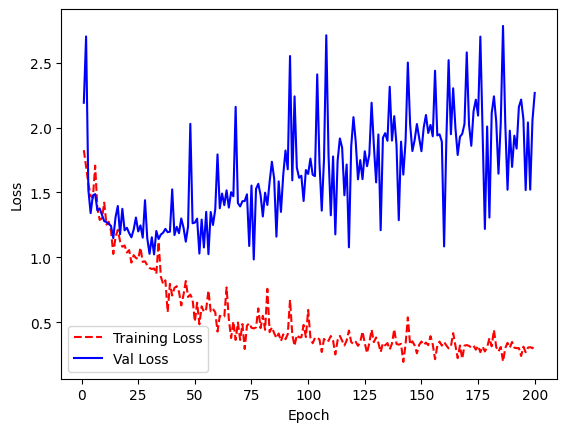

In [14]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

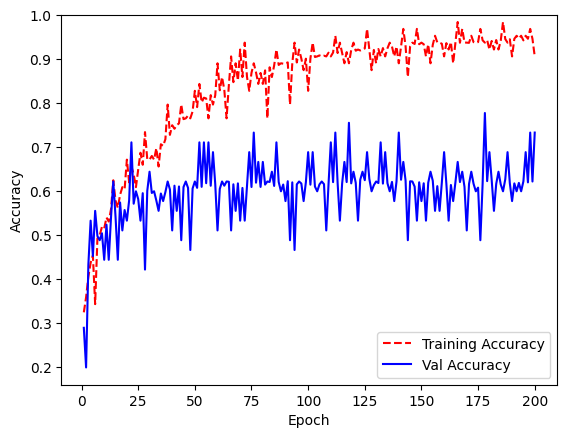

In [15]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

In [16]:
# saving the model
model.save("fer_model.h5")

## Test Accuracy

In [17]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

  2/112 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.5898 - loss: 2.2238

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 249ms/step - accuracy: 0.6241 - loss: 2.0486
Test accuracy = 62.82086968421936%


## Confusion Matrix

### Confusion matrix on Training Set

359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step
Confusion Matrix
[[ 457   59  447  792  531  539  371]
 [  54   10   58   82   54   58   33]
 [ 489   46  443  805  600  523  372]
 [ 813   83  821 1428 1005 1015  607]
 [ 537   59  566 1033  676  649  452]
 [ 520   59  562  995  659  668  401]
 [ 326   32  398  638  451  407  285]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3196
     disgust       0.03      0.03      0.03       349
        fear       0.13      0.14      0.13      3278
       happy       0.25      0.25      0.25      5772
     neutral       0.17      0.17      0.17      3972
         sad       0.17      0.17      0.17      3864
    surprise       0.11      0.11      0.11      2537

    accuracy                           0.17     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.17      0.17     22968



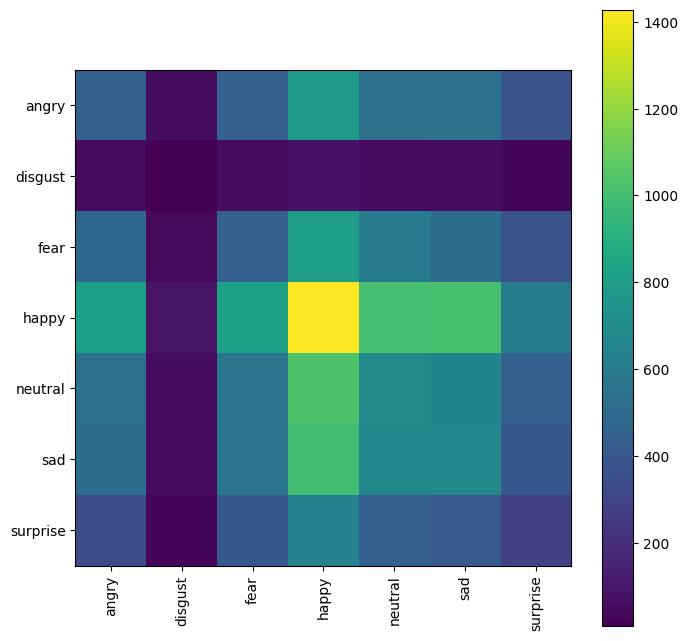

In [18]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion Matrix on Validation Dataset

90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step
Confusion Matrix
[[118  12  91 198 162 138  80]
 [ 10   1  17  24  14  18   3]
 [103  12 106 219 154 130  95]
 [193  13 198 373 280 242 144]
 [134   7 152 261 185 166  88]
 [129   9 120 257 192 162  97]
 [ 72   6  87 150 122 123  74]]
Classification Report
              precision    recall  f1-score   support

       angry       0.16      0.15      0.15       799
     disgust       0.02      0.01      0.01        87
        fear       0.14      0.13      0.13       819
       happy       0.25      0.26      0.26      1443
     neutral       0.17      0.19      0.18       993
         sad       0.17      0.17      0.17       966
    surprise       0.13      0.12      0.12       634

    accuracy                           0.18      5741
   macro avg       0.15      0.15      0.15      5741
weighted avg       0.18      0.18      0.18      5741



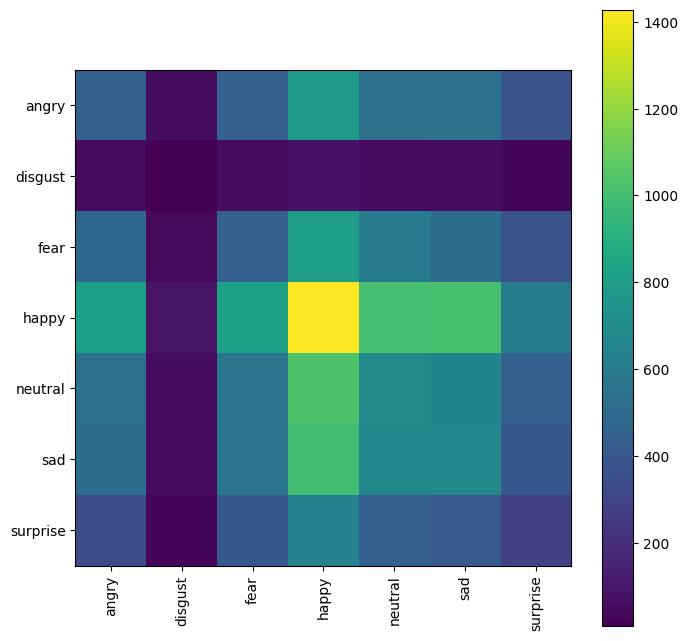

In [19]:
y_pred = model.predict(validation_set)
y_pred = np.argmax(y_pred, axis=1)
cm_val = confusion_matrix(validation_set.classes, y_pred)
print('Confusion Matrix')
print(cm_val)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## Confusion Matrix on Test Dataset

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step
Confusion Matrix
[[126  10 135 244 175 166 102]
 [ 15   3  11  24  22  20  16]
 [134   8 120 270 181 199 112]
 [256  17 246 441 311 327 176]
 [137  13 166 321 264 213 119]
 [156  16 154 305 240 226 150]
 [106  10  99 218 165 151  82]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.13       958
     disgust       0.04      0.03      0.03       111
        fear       0.13      0.12      0.12      1024
       happy       0.24      0.25      0.25      1774
     neutral       0.19      0.21      0.20      1233
         sad       0.17      0.18      0.18      1247
    surprise       0.11      0.10      0.10       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.17      0.18      0.17      7178



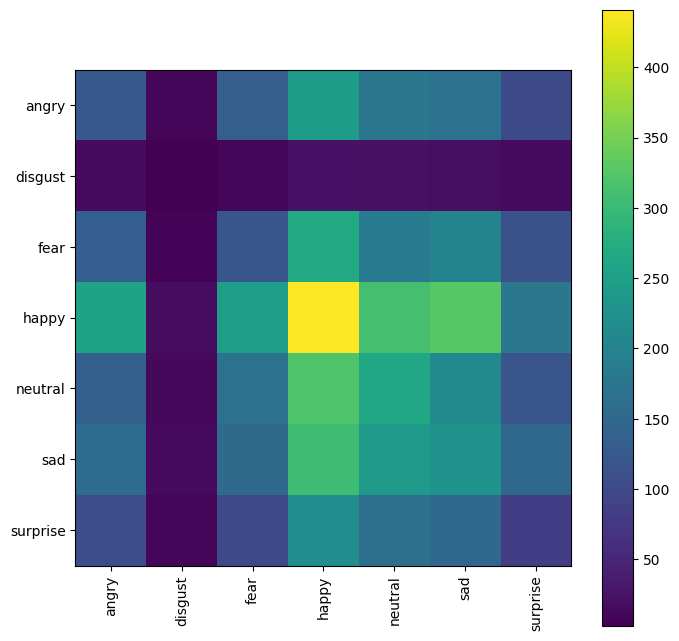

In [20]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## Plotting Predictions

In [21]:
# next function assigns one batch to variables, i.e x_test,y_test will have 64 images
x_test,y_test = next(test_set)
predict = model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


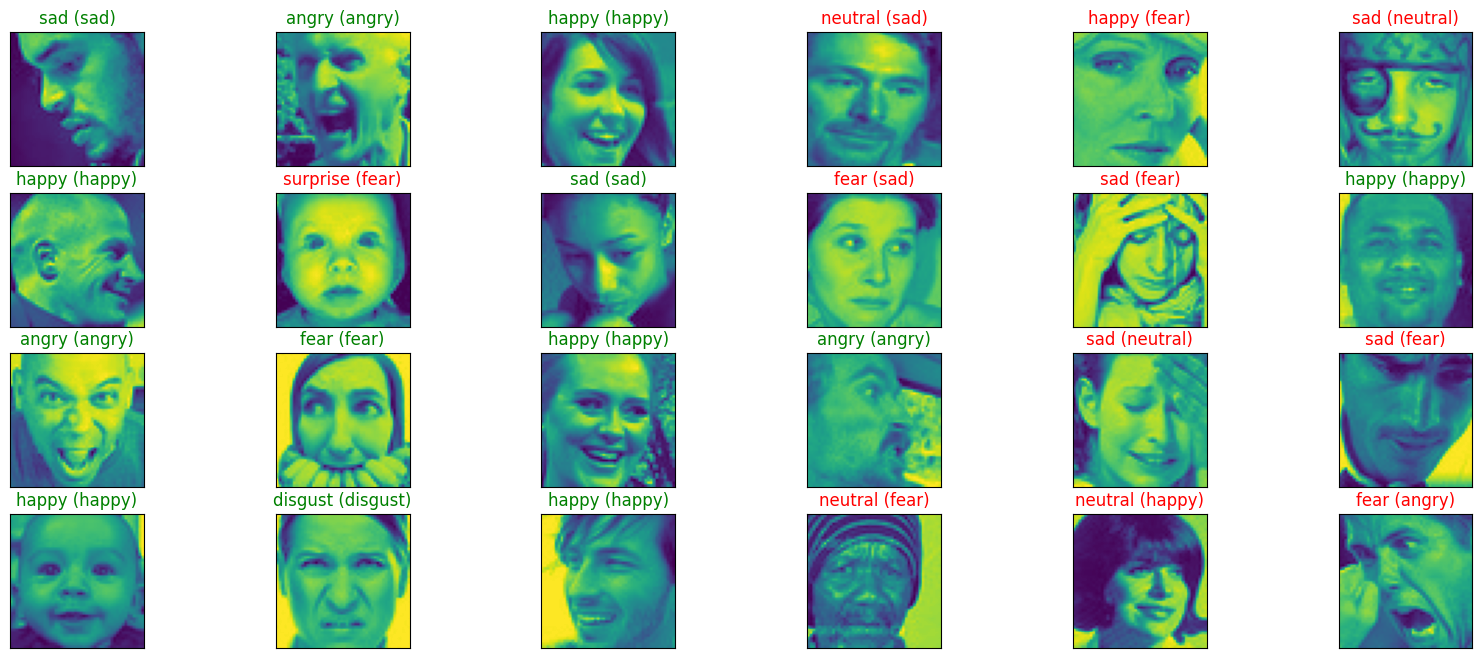

In [22]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))